In [1]:
%load_ext autoreload
%autoreload 2

In [167]:
import argparse
import os
import sys

import mlflow
import numpy as np
import scanpy as sc
import squidpy as sq

from autotalker.data import load_spatial_adata_from_csv
from autotalker.models import Autotalker
from autotalker.utils import download_nichenet_ligand_target_mx
from autotalker.utils import extract_gps_from_ligand_target_mx
from autotalker.utils import add_binary_gp_mask_to_adata
from autotalker.utils import extract_gps_from_omnipath_lr_interactions

In [3]:
dataset = "squidpy_seqfish"

In [4]:
print(f"Using dataset {dataset}.")

if dataset == "deeplinc_seqfish":
    adata = load_spatial_adata_from_csv("datasets/seqFISH/counts.csv",
                                        "datasets/seqFISH/adj.csv")
    cell_type_key = None
elif dataset == "squidpy_seqfish":
    adata = sq.datasets.seqfish()
    sq.gr.spatial_neighbors(adata, radius = 0.04, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"
elif dataset == "squidpy_slideseqv2":
    adata = sq.datasets.slideseqv2()
    sq.gr.spatial_neighbors(adata, radius = 30.0, coord_type="generic")
    cell_type_key = "cluster"

Using dataset squidpy_seqfish.


In [5]:
print(f"Number of nodes: {adata.X.shape[0]}")
print(f"Number of node features: {adata.X.shape[1]}")
avg_edges_per_node = round(
    adata.obsp['spatial_connectivities'].toarray().sum(axis=0).mean(),2)
print(f"Average number of edges per node: {avg_edges_per_node}")
n_edges = int(np.triu(adata.obsp['spatial_connectivities'].toarray()).sum())
print(f"Number of edges: {n_edges}", sep="")

Number of nodes: 19416
Number of node features: 351
Average number of edges per node: 4.4
Number of edges: 42694


In [6]:
os.makedirs("mlruns", exist_ok=True)

In [7]:
experiment = mlflow.set_experiment("autotalker")
mlflow.log_param("dataset", dataset)

In [44]:
# Mask that allows all genes
mask = np.ones((16, len(adata.var)))
mask.shape

(16, 351)

In [12]:
model = Autotalker(adata,
                   autotalker_module="VGPGAE",
                   n_hidden_encoder=32,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_mask=mask)

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
GCN ENCODER -> n_input: 351, n_hidden: 32, n_latent: 16, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 16, n_output: 351


In [13]:
model.train(n_epochs=20,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            node_test_ratio=0.0,
            edge_batch_size=64,
            include_edge_recon_loss=True,
            include_gene_expr_recon_loss=True,
            mlflow_experiment_id=experiment.experiment_id)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of test nodes: 0
Number of training edges: 36291
Number of validation edges: 4269
Number of test edges: 2134

--- MODEL TRAINING ---
Epoch 1/20 |█-------------------| 5.0% val_auroc_score: 0.8243; val_auprc_score: 0.7837; val_best_acc_score: 0.7530; val_best_f1_score: 0.7966; train_loss: 323.3205; train_edge_recon_loss: 5.7484; train_kl_loss: 0.2292; train_gene_expr_recon_loss: 317.3428; val_loss: 254.3698; val_edge_recon_loss: 1.0113; val_kl_loss: 0.0300; val_gene_expr_recon_loss: 253.3285
Epoch 2/20 |██------------------| 10.0% val_auroc_score: 0.8538; val_auprc_score: 0.8195; val_best_acc_score: 0.7829; val_best_f1_score: 0.8153; train_loss: 252.6746; train_edge_recon_loss: 0.9083; train_kl_loss: 0.0310; train_gene_expr_recon_loss: 251.7353; val_loss: 251.3033; val_edge_recon_loss: 0.7502; val_kl_loss: 0.0306; val_gene_expr_recon_loss: 250.5225
Epoch 3/20 |███-----------------| 15.0%

In [14]:
model.save(dir_path="./model_artefacts",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

In [15]:
model = Autotalker.load(dir_path="./model_artefacts",
                        adata=None,
                        adata_file_name="adata.h5ad")

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
GCN ENCODER -> n_input: 351, n_hidden: 32, n_latent: 16, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 16, n_output: 351


In [16]:
latent = model.get_latent_representation()

In [17]:
latent_new_data = model.get_latent_representation(adata)

In [18]:
adata.obsm["latent_autotalker"] = latent_new_data

## Interoperability with scanpy

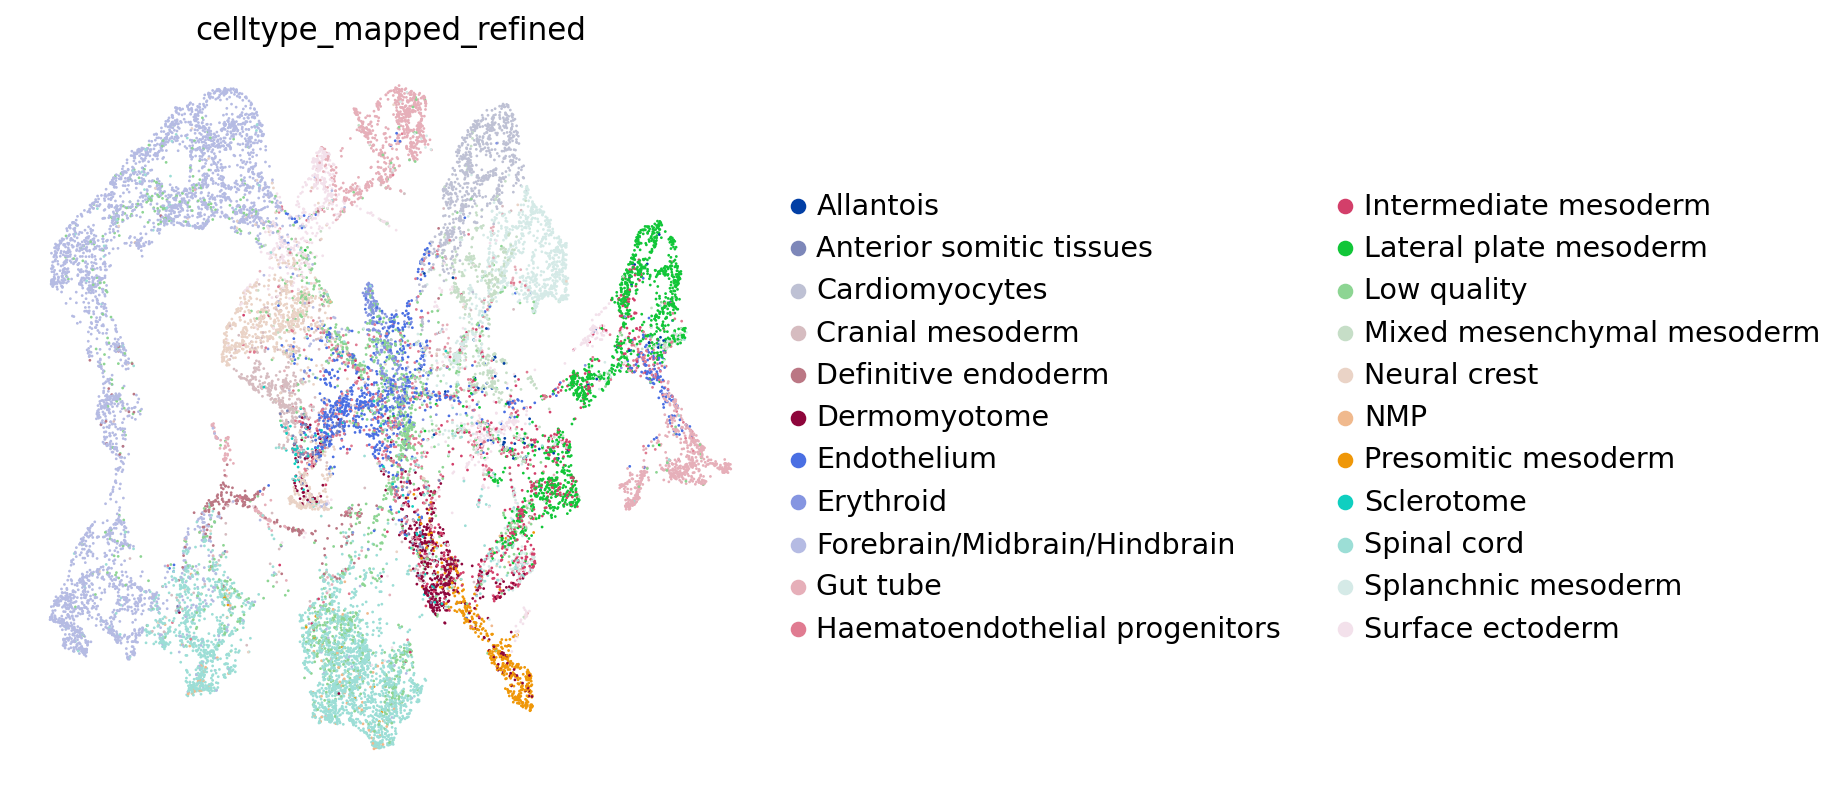

In [20]:
sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save="_latent.png")

## Gene Programs (GPs)

### NicheNet

In [31]:
gp_data_folder_path = "datasets/gp_data"
gp_data_file_path = gp_data_folder_path + "/ligand_target_matrix.csv"
os.makedirs(gp_data_folder_path, exist_ok=True)

In [32]:
download_nichenet_ligand_target_mx(
    save_path=gp_data_file_path)

In [33]:
gp_dict = extract_gps_from_ligand_target_mx(
    path=gp_data_file_path)

In [114]:
add_binary_gp_mask_to_adata(adata=adata,
                            gp_dict=gp_dict)

### OmniPath

In [ ]:
lr_interactions = retrieve_omnipath_lr_interactions()

In [182]:
lr_gp_dict = extract_gps_from_omnipath_lr_interactions()

In [183]:
lr_gp_dict

{'BDNF': ['DRD4'],
 'EPOR': ['STAT3'],
 'FYN': ['MAPK7'],
 'AVP': ['AQP2'],
 'NGF': ['SMPD2'],
 'NTF3': ['NTRK3'],
 'KL': ['FGFR4'],
 'S100A10': ['HTR1B'],
 'TP53': ['THBS1'],
 'TNF': ['CHI3L1'],
 'CALML3': ['ADCY3'],
 'IFNG': ['XDH'],
 'GNRH1': ['GNRHR2'],
 'PTPN6': ['CLEC12A'],
 'IL1A': ['MAPKAPK3'],
 'EDN1': ['CYSLTR1'],
 'NPPA': ['PRKG1'],
 'VIP': ['VIPR2'],
 'SST': ['SSTR4'],
 'PTH': ['HDAC4'],
 'IL16': ['GRIN2C'],
 'CCL4': ['SLC7A1'],
 'CXCL12': ['AVPR1A'],
 'AGT': ['MAS1'],
 'CCL11': ['PIK3C2G'],
 'NTN1': ['ADORA2B'],
 'KIT': ['PTPRO'],
 'EGF': ['SLC12A2'],
 'PTPN11': ['MAP3K4'],
 'IL2': ['CES1'],
 'PDGFB': ['ADGRV1'],
 'EFNB3': ['SYNJ1'],
 'EFNB2': ['KIR2DS3'],
 'EFNB1': ['MMP8'],
 'LGALS3': ['LAG3'],
 'AGER': ['CSNK2A2'],
 'FRS3': ['FGFR1'],
 'S100A1': ['TRPM3'],
 'GSTO1': ['RYR1'],
 'CXCL9': ['ADRA2A'],
 'CCL5': ['TNFRSF4'],
 'CXCL10': ['TLR4'],
 'CXCL11': ['ACKR3'],
 'CCL19': ['CCRL2'],
 'CCL21': ['CXCL10'],
 'CCL25': ['ADRA2A'],
 'APLN': ['CMKLR2'],
 'KNG1': ['CTSG'],
 'CCL

In [153]:
lr_interactions = retrieve_omnipath_lr_interactions()

In [159]:
lr_interactions

,genesymbol_intercell_source,genesymbol_intercell_target
42,BDNF,TRPC1
69,EPOR,TRPC3
111,FYN,TRPC6
132,AVP,TRPC6
186,NGF,TRPV1
...,...,...
94928,MANSC1,GPR55
94930,MSMB,GPR55
94931,SPAG11B,GPR55
94932,COPA,P2RY6


In [47]:
experiment = mlflow.set_experiment("autotalker_gp_masked")
mlflow.log_param("dataset", dataset)

2022/09/01 21:08:47 INFO mlflow.tracking.fluent: Experiment with name 'autotalker_gp_masked' does not exist. Creating a new experiment.


In [115]:
gp_mask = adata.varm["autotalker_gps"].T
print(f"Gene program mask shape (gene programs x nodes): {gp_mask.shape}")
n_hidden_encoder = int(gp_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {n_hidden_encoder}")

Gene program mask shape (gene programs x nodes): (665, 351)
Number of hidden layers in the encoder: 332


In [57]:
model = Autotalker(adata,
                   autotalker_module="VGPGAE",
                   n_hidden_encoder=n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_mask=gp_mask)

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
GCN ENCODER -> n_input: 351, n_hidden: 332, n_latent: 665, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 665, n_output: 351


In [61]:
model.train(n_epochs=20,
            lr=0.001,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            node_test_ratio=0.0,
            edge_batch_size=64,
            include_edge_recon_loss=True,
            include_gene_expr_recon_loss=True,
            mlflow_experiment_id=experiment.experiment_id)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of test nodes: 0
Number of training edges: 36291
Number of validation edges: 4269
Number of test edges: 2134

--- MODEL TRAINING ---
Epoch 1/20 |█-------------------| 5.0% val_auroc_score: 0.8033; val_auprc_score: 0.7714; val_best_acc_score: 0.7382; val_best_f1_score: 0.7675; train_loss: 1004.0666; train_edge_recon_loss: 0.8014; train_kl_loss: 0.6235; train_gene_expr_recon_loss: 1002.6416; val_loss: 981.9729; val_edge_recon_loss: 0.5463; val_kl_loss: 0.2709; val_gene_expr_recon_loss: 981.1557
Epoch 2/20 |██------------------| 10.0% val_auroc_score: 0.8391; val_auprc_score: 0.8209; val_best_acc_score: 0.7618; val_best_f1_score: 0.7824; train_loss: 957.1693; train_edge_recon_loss: 0.5077; train_kl_loss: 0.2757; train_gene_expr_recon_loss: 956.3859; val_loss: 933.4169; val_edge_recon_loss: 0.4644; val_kl_loss: 0.2643; val_gene_expr_recon_loss: 932.6882
Epoch 3/20 |███-----------------| 15.

The model can maintain the edge reconstruction performance while tweaking the latent space for better gene expression reconstruction.

In [62]:
latent_gps = model.get_latent_representation()

In [63]:
latent_gps_new_adata = model.get_latent_representation(adata)

In [68]:
adata.obsm["latent_gps_autotalker"] = latent_gps_new_adata

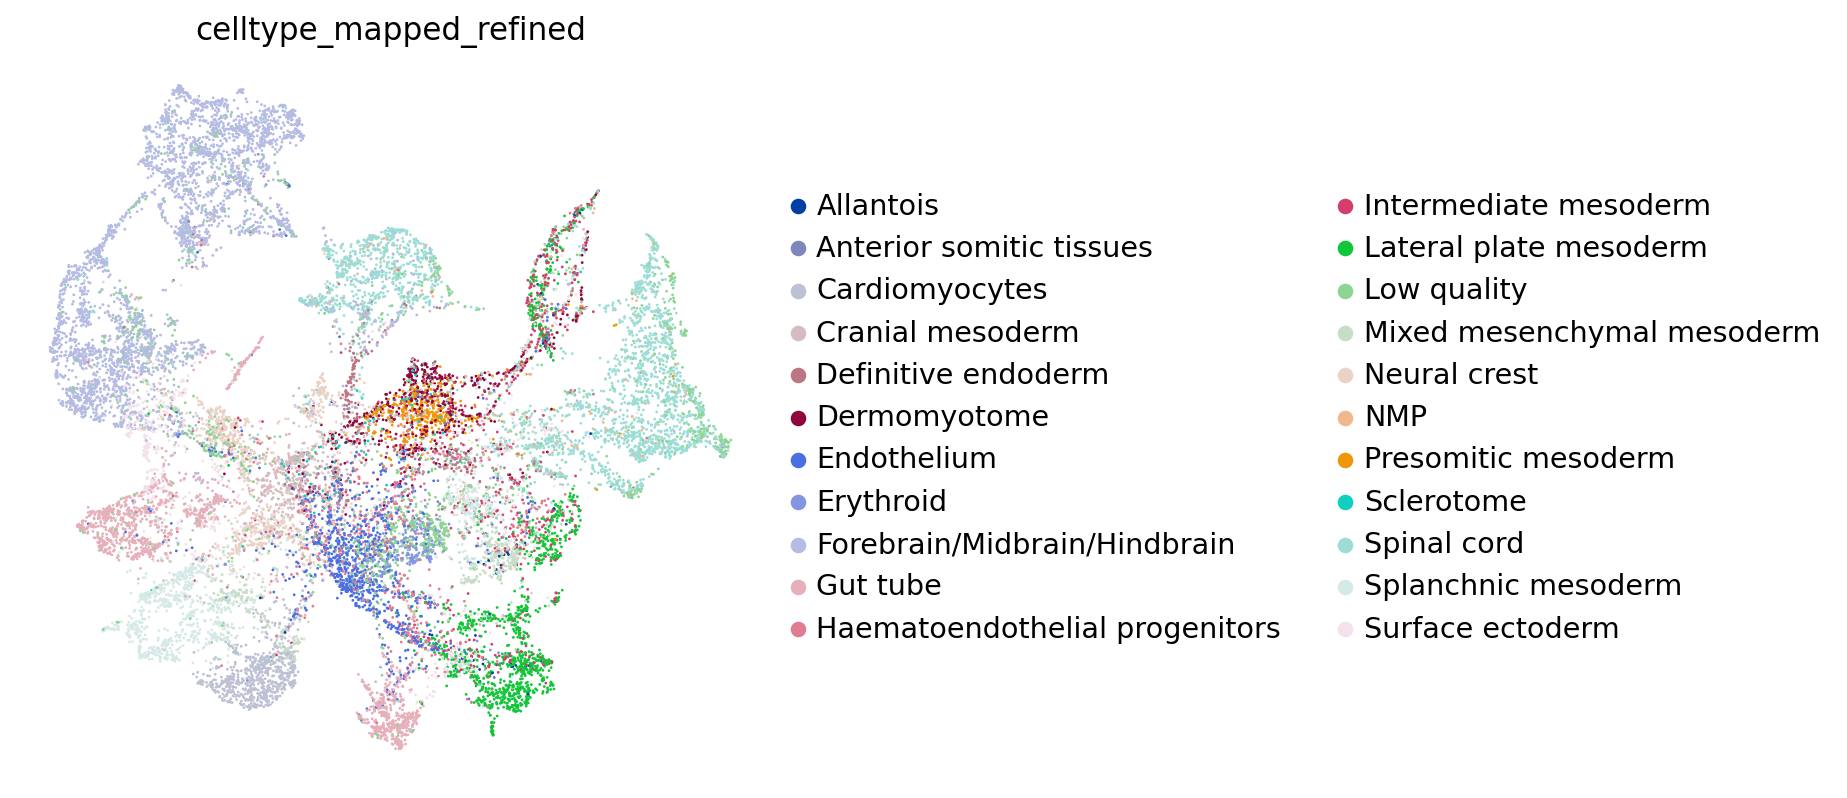

In [69]:
sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent gp space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_gps_autotalker")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False)

In [80]:
gp_mask.shape

(665, 351)

In [131]:
gene_programs = adata.uns["gene_programs"]
selected_gene_programs = ["CSF1", "IL34"]
selected_gene_programs_idx = [gene_programs.index(gene_program) for gene_program in selected_gene_programs]

In [132]:
latent_selected_gps = latent_gps[:, selected_gene_programs_idx]

In [133]:
adata.obs["CSF1"] = latent_selected_gps[:, 0]
adata.obs["IL34"] = latent_selected_gps[:, 1]

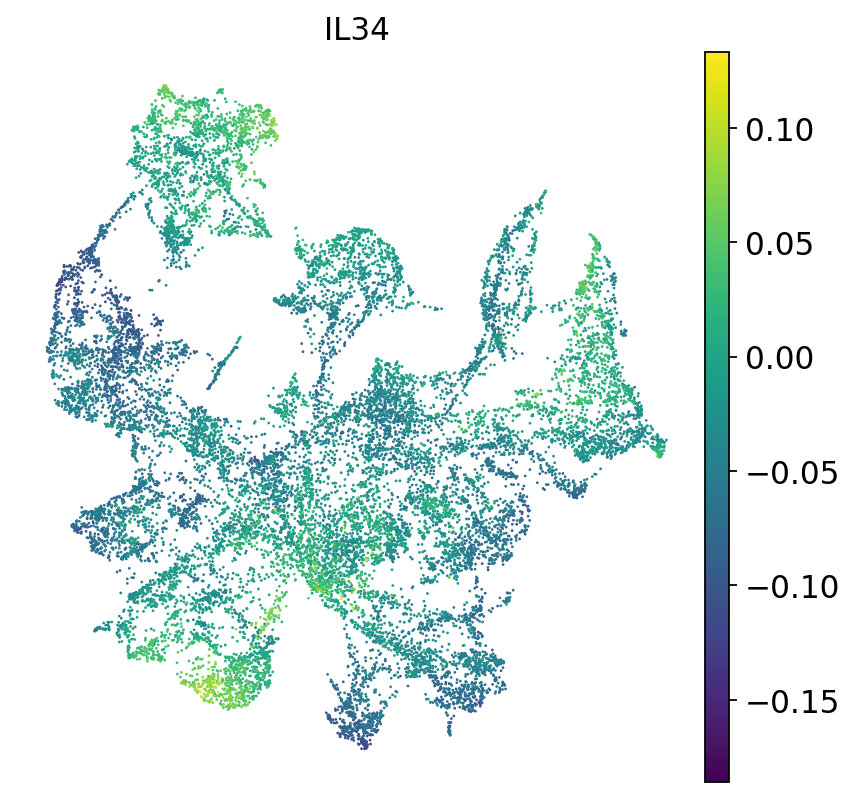

In [135]:
sc.pl.umap(adata, color="IL34", frameon=False, wspace=0.6)

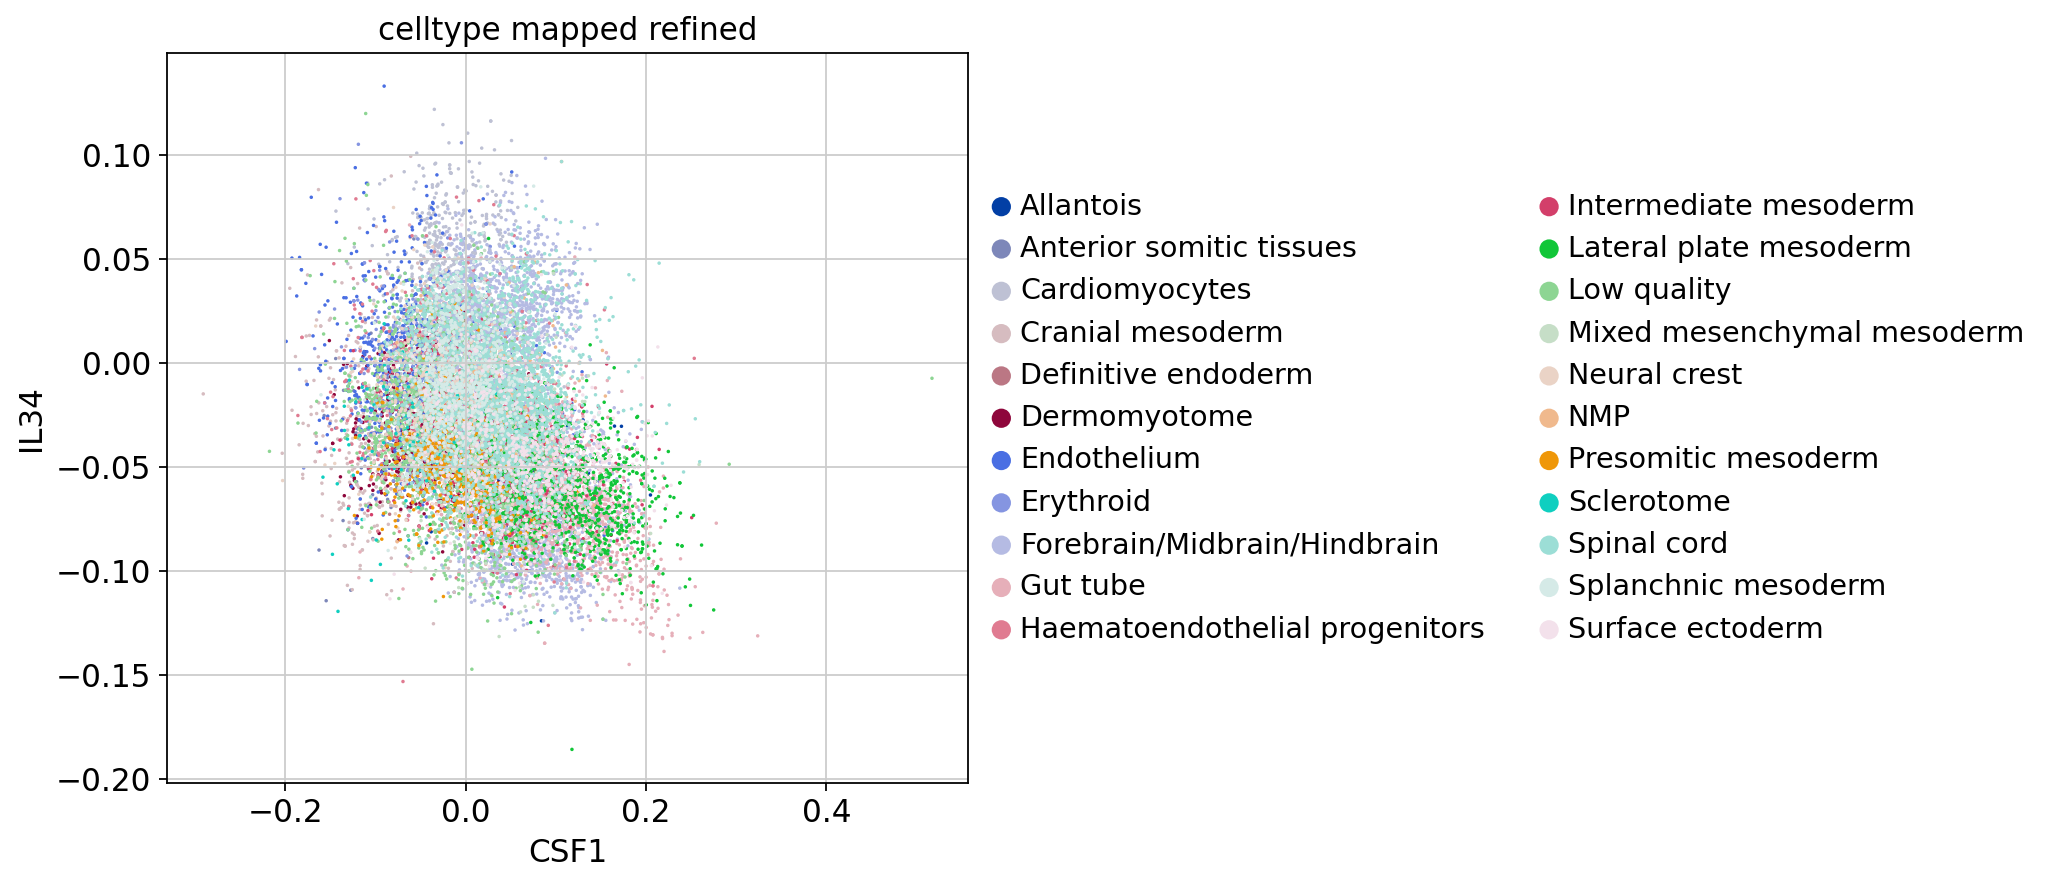

In [136]:
sc.pl.scatter(adata, x="CSF1", y="IL34", color=cell_type_key, size=10)

## SCVI

In [21]:
import scvi
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(6, 6))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0


In [22]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [23]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts"
)

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scvi/data/_utils.py:114: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [24]:
model = scvi.model.SCVI(adata)

In [25]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

In [26]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [06:53<00:00,  1.03s/it, loss=265, v_num=1]


In [27]:
latent_scvi = model.get_latent_representation()

In [28]:
adata.obsm["X_scVI"] = latent_scvi

In [29]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

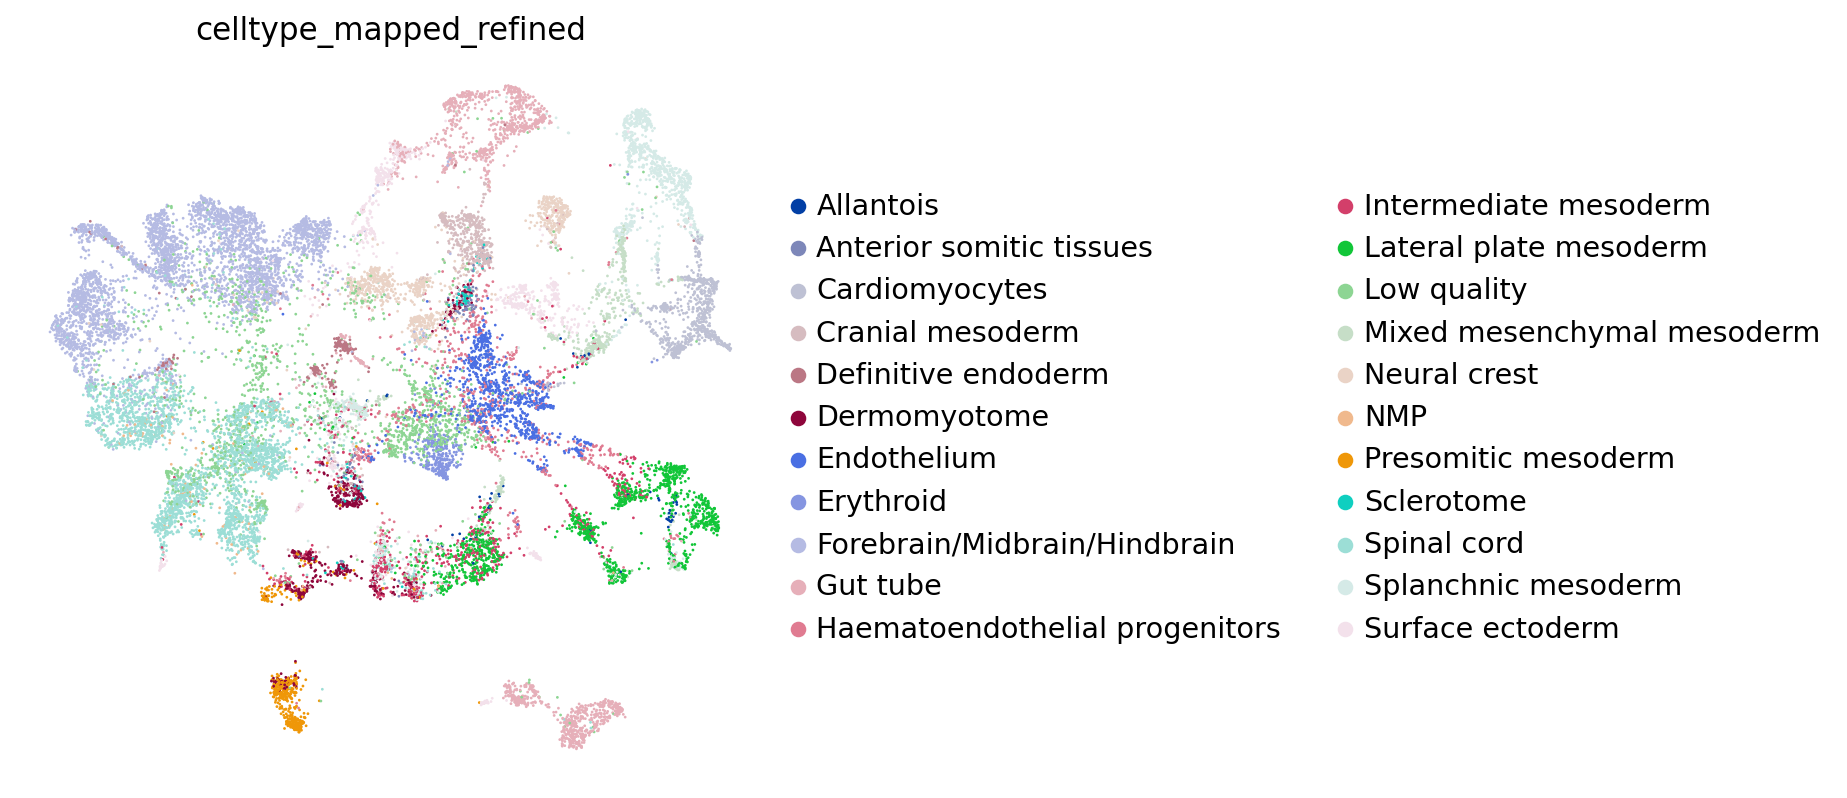

In [30]:
sc.pl.umap(adata, color=["celltype_mapped_refined"], frameon=False,)